In [19]:
import torch 
import pytorch_lightning as pl 
from utils import pl_module

device = torch.device('cuda:2')

In [20]:
clf_module = pl_module.ImageClassifier.load_from_checkpoint('./logs/clf/resnet20/cifar10/lightning_logs/version_0/checkpoints/saved_epoch=18.ckpt', map_location=torch.device('cpu'))
clf = clf_module.clf 
clf.eval()
clf.requires_grad_(False)
clf = clf.to(device)

Using cache found in /home/shreyasc/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


In [21]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from einops import rearrange

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified


In [22]:
snr = 30
img, label = test_dataset[10]
img.unsqueeze_(0)

B, C, H, W = img.shape
img_sqnorm = torch.sum(torch.square(img), dim=(1,2,3))
noise_std = torch.sqrt(img_sqnorm / ((C*H*W) * (10**(snr/10))))
noise = torch.randn(10000, C, H, W)
noisy_imgs = rearrange(img, 'B C H W -> B 1 C H W') + rearrange(noise, 'M C H W -> 1 M C H W') * rearrange(noise_std, 'B -> B 1 1 1 1')
noisy_imgs = rearrange(noisy_imgs, 'B M C H W -> (B M) C H W')


with torch.no_grad():
    out = clf(noisy_imgs.to(device)) 
    out = out.softmax(dim=-1)
    pred = out.argmax(dim=-1)

pred = torch.bincount(pred, minlength=10) 
pred = pred / torch.sum(pred)
print(pred)

tensor([0.9918, 0.0000, 0.0000, 0.0000, 0.0082, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000], device='cuda:2')


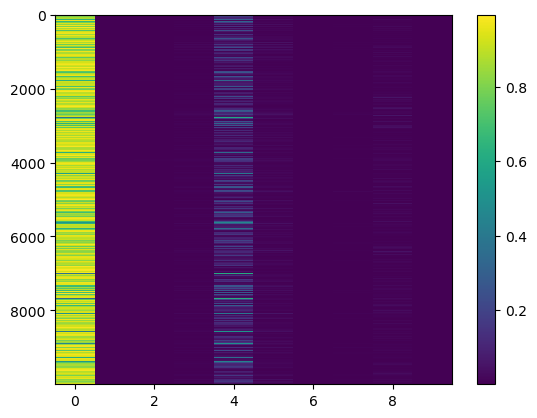

In [23]:
import matplotlib.pyplot as plt 
plt.imshow(out.cpu(), aspect='auto', interpolation='nearest')
plt.colorbar()



with torch.no_grad():
    mean_out = clf(img.to(device))
    mean_out = torch.softmax(mean_out, dim=-1).cpu()

<StemContainer object of 3 artists>

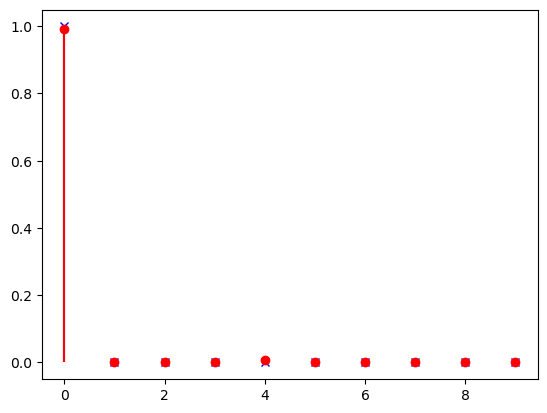

In [24]:
plt.figure()
plt.stem(mean_out.flatten(), linefmt='b-', markerfmt='bx', basefmt=' ')
plt.stem(pred.cpu().flatten(), linefmt='r-', markerfmt='ro', basefmt=' ')